<p>Queries:</p>
<p>
<ul>
  <li>Why 0.5 in all the <code>stats</code>.
  <li>Why <code>bias=False</code> in convolution layer.</li>
<ul>
</p>

# Anime faces GAN

## Importing Libraries

In [1]:
!pip install opendatasets -q

In [19]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.utils import save_image

import opendatasets as od
from PIL import Image
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm

## Loading Dataset

### Downloading Data

In [4]:
def download_data(url = 'https://www.kaggle.com/splcher/animefacedataset'):
  od.download(url, force=True)

download_data()

100%|██████████| 395M/395M [00:06<00:00, 61.0MB/s]


#### Random Image

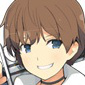

In [5]:
img = Image.open("./animefacedataset/images/49679_2015.jpg")
img

### Preparing DataLoader

In [6]:
def Dataloader():
  # Params
  image_size = 64
  batch_size = 128
  stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)  # Channel-wise means, stds

  # Transformations
  transformations = Compose([
      transforms.CenterCrop(size=image_size),
      transforms.Resize(size=image_size),
      transforms.RandomHorizontalFlip(0.5),
      transforms.ToTensor(),
      transforms.Normalize(*stats),
  ])

  # Dataset
  train_ds = ImageFolder(
      "./animefacedataset",
      transform=transformations,
  )

  # Dataloader
  dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
  return dataloader

def GetSingleBatch(dl):
  for X, y in dl:
    return X, y

dataloader = Dataloader()

### Utility functions for Images

In [7]:
def denorm(img):
  stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
  return img * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
  fig, ax = plt.subplots(figsize=(8, 8))
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch():
  X, _ = GetSingleBatch(dataloader)
  show_images(X)

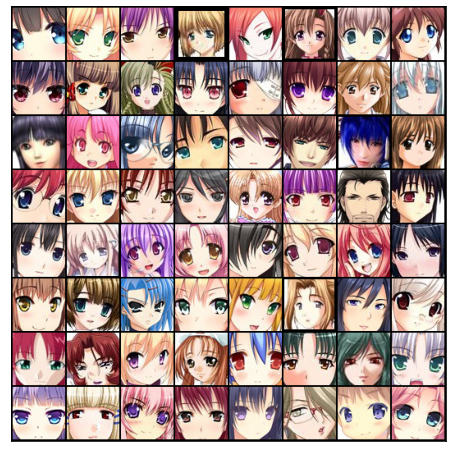

In [8]:
show_batch()

## Utility Functions for GPU

In [9]:
def get_default_device():
  """Pick GPU if available, else CPU"""
  if torch.cuda.is_available():
      return torch.device('cuda')
  else:
      return torch.device('cpu')
  
def to_device(data, device):
  """Move tensor(s) to chosen device"""
  if isinstance(data, (list,tuple)):
      return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

def dataloader_to_device(dl, device):
  return DeviceDataLoader(dl, device)

class DeviceDataLoader():
  """Wrap a dataloader to move data to a device"""
  def __init__(self, dl, device):
      self.dl = dl
      self.device = device
      
  def __iter__(self):
      """Yield a batch of data after moving it to device"""
      for b in self.dl: 
          yield to_device(b, self.device)

  def __len__(self):
      """Number of batches"""
      return len(self.dl)

In [10]:
dataloader = dataloader_to_device(dataloader, get_default_device())

## Discriminator

In [11]:
class Discriminator(nn.Module):
  def __init__(self, in_channels):
    super().__init__()

    self.block_1 = self.block(in_channels, 64)
    self.block_2 = self.block(64, 128)
    self.block_3 = self.block(128, 256)
    self.block_4 = self.block(256, 512)

    self.flatter = nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False)
    self.flatten = nn.Flatten()
    self.sigmoid = nn.Sigmoid()

  def forward(self, inputs):
    inputs = self.block_1(inputs)
    inputs = self.block_2(inputs)
    inputs = self.block_3(inputs)
    inputs = self.block_4(inputs)
    inputs = self.flatter(inputs)
    inputs = self.flatten(inputs)
    inputs = self.sigmoid(inputs)

    return inputs


  def block(self, in_channels, out_channels):
    layers = [
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2, inplace=True),
    ]
    
    return nn.Sequential(*layers)

In [12]:
X, y = GetSingleBatch(dataloader)
model = Discriminator(3)
model = to_device(model, get_default_device())
model(X).shape

torch.Size([128, 1])

In [13]:
class Generator(nn.Module):
  def __init__(self, latent_size):
    super().__init__()
    self.generator = nn.Sequential(
        self.block(latent_size, 512, stride=1, padding=0),
        self.block(512, 256),
        self.block(256, 128),
        self.block(128, 64),
        nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
        nn.Tanh(),
    )

  def forward(self, inputs):
    return self.generator(inputs)

  def block(self, in_channels, out_channels, stride=2, padding=1):
    layers = [
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, padding=padding, stride=stride, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    ]

    return nn.Sequential(*layers)

torch.Size([128, 3, 64, 64])


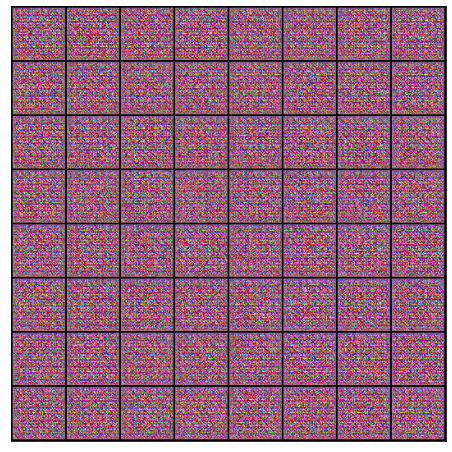

In [44]:
fake_images = Generator(128)(xb)
print(fake_images.shape)
show_images(fake_images)

torch.Size([1, 3, 64, 64])


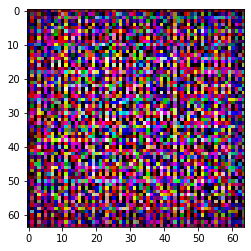

In [45]:
xb = torch.randn(1, 128, 1, 1) # random latent tensors
fake_images = Generator(128)(xb)
print(fake_images.shape)
plt.imshow(fake_images[0].detach().permute(1, 2, 0));

### Training Discriminator

In [52]:
def gan_training():

  # Parameters
  
  batch_size = 128
  latent_size = 128

  # Declaring our loader

  data_loader = Dataloader()
  
  # Declaring our generator and discriminator
  
  discriminator = Discriminator(3)
  generator = Generator(128)

  # Shifting models and loader to available device

  device = get_default_device()

  discriminator = to_device(discriminator, device)
  generator = to_device(generator, device)
  data_loader = DeviceDataLoader(data_loader, device)

  # Fixed Latent space for generation of fake images

  fixed_latent = torch.randn(batch_size, latent_size, 1, 1, device=device)

  # Discriminator Training

  def training_discriminator(real_images, optimizer_discriminator):

    # Reset gradients of discriminator's optimizer
    optimizer_discriminator.zero_grad()

    # Passing real images and scoring them for our discriminator

    real_predictions = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device) # real_images.size(0) is the batch_size?
    real_loss = F.binary_cross_entropy(real_predictions, real_targets)
    real_score = real_predictions.mean().item()

    # Generating fake images

    fake_images = generator(fixed_latent)

    # Passing fake images to the discriminator

    fake_predictions = discriminator(fake_images)
    fake_targets = torch.zeros(real_images.size(0), 1, device=device)
    fake_loss = F.binary_cross_entropy(fake_predictions, fake_targets)
    fake_score = fake_loss.mean().item()

    # Total Loss

    loss = real_loss + fake_loss
    
    # Backprop

    loss.backward()
    optimizer_discriminator.step()

    return loss.item(), real_score, fake_score

  # Generator Training

  def training_generator(optimizer_generator):

    # Reset gradients

    optimizer_generator.zero_grad()

    # Generating fake images

    # latent_space = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(fixed_latent)

    # Fooling the discriminator

    discriminator_predictions = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(discriminator_predictions, targets)

    # Backprop

    loss.backward()
    optimizer_generator.step()

    return loss.item()

  # Utility function to save generated samples

  def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join("generated", fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

  # Training Loop

  def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores

    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(dataloader):
          # Train discriminator
          loss_d, real_score, fake_score = training_discriminator(real_images, opt_d)
          # Train generator
          loss_g = training_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

  # Save Models

  def save_model():
    print("Saving Discriminator...")
    torch.save(discriminator.state_dict(), "./models/discriminator.pth")
    print("Saving Generator...")
    torch.save(generator.state_dict(), "./models/generator.pth")

  # Finally, let's train

  fit(10, 0.003)
  save_model()

In [54]:
gan_training()

  0%|          | 0/497 [00:00<?, ?it/s]

Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, b

KeyboardInterrupt: ignored

In [ ]:
 def training_discriminator(real_images, optimizer_discriminator):
  optimizer_discriminator.zero_grad()

  return